In [39]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sb
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import gensim
from gensim.models import Word2Vec, KeyedVectors

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape)

(525814, 10)


## 1) Data Cleaning: Deduplication

In [4]:
# Sorting data points according to the 'ProductId'
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Eliminating the duplicate data points based on: 'UserId', 'ProfileName', 'Time', 'Summary'
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Summary'}, keep='first', inplace=False)
# Eliminating the row where 'HelpfulnessDenominator' is greater than 'HelpfulnessNumerator' as these are the wrong entry
final = final[final['HelpfulnessDenominator'] >= final['HelpfulnessNumerator']]
# Getting shape of final data frame
#display(final.shape)

In [5]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(363224, 10)


1    306208
0     57016
Name: Score, dtype: int64

## 2)Text Preprocessing
Remove stop words

Stemming

Lematization

Convert lower case

In [6]:
# Creating the set of stopwords
stop = set(stopwords.words('english'))

# For stemming purpose
snow = nltk.stem.SnowballStemmer('english')

# Defining function to clean html tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*>')
    cleantext = re.sub(cleaner, ' ', sentence)
    return cleantext

# Defining function to remove special symbols
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|.|!|*|@|#|\'|"|,|)|(|\|/]', r'', sentence)
    return cleaned


In [7]:
final.shape

(363224, 10)

In [8]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [9]:
final.shape

(363224, 10)

In [10]:
# Important steps to clean the text data. Please trace it out carefully
i = 0
str1 = ''
all_positive_words = []
all_negative_words = []
final_string = []
s=''
for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if (cleaned_words.lower() not in stop):
                    s = (snow.stem(cleaned_words.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1:
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 0:
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i += 1
    
# Adding new column into dataframe to store cleaned text
final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')

# Creating new dataset with cleaned text for future use
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Getting shape of new datset
print(final.shape)

(363224, 11)


In [11]:
final['Score'].value_counts()

1    306208
0     57016
Name: Score, dtype: int64

In [13]:
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


# Collecting 100k rows without repetition from time_sorted_data dataframe
#my_final = data.take(np.random.permutation(len(final))[:100000])
#print(my_final.shape)
# To get 2k +ve and 2k -ve reviews randomly.
data_pos = data[data["Score"] == 1].sample(n = 100000)
data_neg = data[data["Score"] == 0].sample(n = 50000)
my_final = pd.concat([data_pos, data_neg])



In [14]:
from sklearn.model_selection import train_test_split
x = my_final['CleanedText'].values
y = my_final['Score']

In [15]:
print(x.shape)

(150000,)


In [16]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

## Bag of Words

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
from sklearn import preprocessing
count_vect = CountVectorizer(min_df = 50) 
X_train    = count_vect.fit_transform(X_train)
X_cv       = count_vect.transform(X_cv)
X_test     = count_vect.transform(X_test)
#print("the type of count vectorizer :",type(X_train))
#print("the shape of out text BOW vectorizer : ",X_train.get_shape())
#print("the number of unique words :", X_train.get_shape()[1])


In [18]:
X_train.shape

(73500, 3002)

In [19]:
X_cv.shape

(31500, 3002)

In [20]:
X_test.shape

(45000, 3002)

In [21]:
from sklearn.calibration import CalibratedClassifierCV

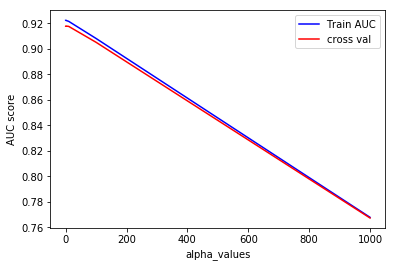

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from matplotlib.legend_handler import HandlerLine2D

alpha_values = []
alpha        = 0.0001
while(alpha <= 1000):
    alpha_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for alpha in alpha_values:
    model = MultinomialNB(alpha = alpha)
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(alpha_values, train_pred, 'b', label = "Train AUC")
plt.plot(alpha_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha_values')
plt.show()





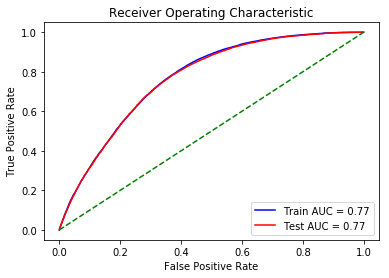

In [23]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
optimal_model = MultinomialNB(alpha = alpha)
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [25]:
bow_features = count_vect.get_feature_names()
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting
feat_count = optimal_model.feature_count_
feat_count.shape

(2, 3002)

In [26]:
log_prob = optimal_model.feature_log_prob_
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(3002, 2)

In [27]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -5.625971
like      -5.699851
product   -5.805840
one       -6.115359
flavor    -6.181564
would     -6.203194
tri       -6.206756
good      -6.363576
coffe     -6.396908
buy       -6.410266
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -5.426239
tast      -5.481977
love      -5.567471
good      -5.579615
great     -5.633021
flavor    -5.657964
use       -5.696451
product   -5.770715
one       -5.784730
tri       -5.813135
Name: 1, dtype: float64


In [28]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.96      0.06      0.12     15223
          1       0.68      1.00      0.81     29777

avg / total       0.77      0.68      0.57     45000



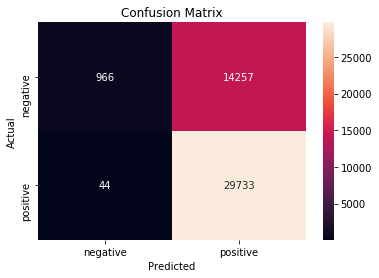

In [29]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## TF-IDF

In [30]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [31]:
# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))

# Fitting for tfidf vectorization
X_train = tfidf_vect.fit_transform(X_train)
X_cv = tfidf_vect.transform(X_cv)
X_test = tfidf_vect.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(73500, 40504) (45000, 40504) (73500,) (45000,)


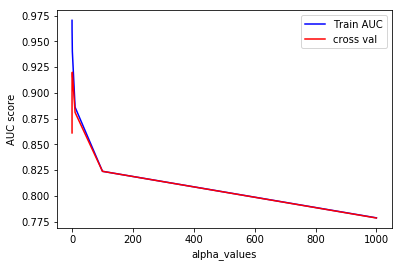

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from matplotlib.legend_handler import HandlerLine2D

alpha_values = []
alpha        = 0.0001
while(alpha <= 1000):
    alpha_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for alpha in alpha_values:
    model = MultinomialNB(alpha = alpha)
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(alpha_values, train_pred, 'b', label = "Train AUC")
plt.plot(alpha_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('alpha_values')
plt.show()





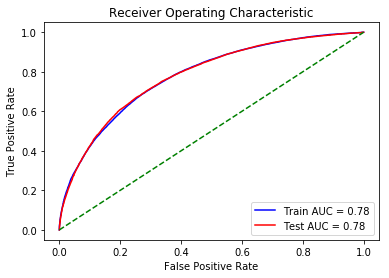

In [33]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
bow_features = count_vect.get_feature_names()
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting
feat_count = model.feature_count_
feat_count.shape

(2, 40504)

In [35]:
#To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -5.625971
like      -5.699851
product   -5.805840
one       -6.115359
flavor    -6.181564
would     -6.203194
tri       -6.206756
good      -6.363576
coffe     -6.396908
buy       -6.410266
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -5.426239
tast      -5.481977
love      -5.567471
good      -5.579615
great     -5.633021
flavor    -5.657964
use       -5.696451
product   -5.770715
one       -5.784730
tri       -5.813135
Name: 1, dtype: float64


In [36]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.96      0.06      0.12     15223
          1       0.68      1.00      0.81     29777

avg / total       0.77      0.68      0.57     45000



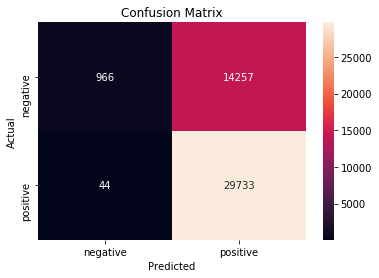

In [37]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [40]:
from prettytable import PrettyTable
x = PrettyTable()

In [41]:
x.field_names = ["Type","Model", "AUC"]
x.add_row(["Bag of Words","MultinomialNB",0.77])
x.add_row(["Tf-idf","MultinomialNB",0.78])

print(x)

+--------------+---------------+------+
|     Type     |     Model     | AUC  |
+--------------+---------------+------+
| Bag of Words | MultinomialNB | 0.77 |
|    Tf-idf    | MultinomialNB | 0.78 |
+--------------+---------------+------+


## Conclusion
By comparing the two developed models, Naive base model with tfidf feature generation technique gives auc 0.78 which is the best to predict the polarity of reviews among all the models 